In [1]:
from pathlib import Path
notebook_path = Path().cwd().parent.parent.parent.parent
import sys; sys.path.insert(0, str(notebook_path))

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

# custom functions
from explore.gcp.storage import gcp
from explore.src.utilities.eda_funcs import describe_data
from explore.src.visualisation.valuations_visual import PlayerValsPlots
from explore.src.preprocess.clean_valuations import CleanPlayerVals

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
# read in serie a data
df = gcp.read_df_from_bucket(bucket_name='processed_transfermarkt_db', blob_name='processed_serie_a_player_valuations.csv')

[03/21/24 18:18:50] INFO     explore.gcp.storage - [ MainThread:get_gcp_bucket:28 ] - Getting GCP bucket                                 ]8;id=528417;file:///Users/conal/Projects/fpl_app/exploration/explore/gcp/storage.py\storage.py]8;;\:]8;id=229239;file:///Users/conal/Projects/fpl_app/exploration/explore/gcp/storage.py#28\28]8;;\

                    INFO     explore.gcp.storage - [ MainThread:get_gcp_bucket:33 ] - GCP bucket retrieved                               ]8;id=856685;file:///Users/conal/Projects/fpl_app/exploration/explore/gcp/storage.py\storage.py]8;;\:]8;id=887334;file:///Users/conal/Projects/fpl_app/exploration/explore/gcp/storage.py#33\33]8;;\

In [3]:
df.head()

,tm_id,tm_name,player,squad_num,position,age,country,current_club,height,foot,signed_date,signed_from,signing_fee_euro_mill,contract_expiry,market_value_euro_mill,season,league,team,signed_year,player_id
0,44058,wojciech-szczesny,Wojciech Szczesny,23,Goalkeeper,28,Poland,Juventus FC,196.0,right,"Jul 19, 2017",Arsenal FC,18.0,NaN,20.0,2017,serie_a,juventus-turin,2017.0,NaN
1,5023,gianluigi-buffon,Gianluigi Buffon,1,Goalkeeper,40,Italy,Retired,192.0,right,"Jul 4, 2019",Paris Saint-Germain,0.0,NaN,2.0,2017,serie_a,juventus-turin,2019.0,359.0
2,75411,carlo-pinsoglio,Carlo Pinsoglio,16,Goalkeeper,28,Italy,Juventus FC,194.0,left,"Jul 1, 2014",Vicenza Calcio,0.8,NaN,0.5,2017,serie_a,juventus-turin,2014.0,1882.0
3,265079,mattia-del-favero,Mattia Del Favero,32,Goalkeeper,20,Italy,SPAL,190.0,right,-,NaN,0.0,NaN,0.1,2017,serie_a,juventus-turin,NaN,NaN
4,386567,leonardo-loria,Leonardo Loria,35,Goalkeeper,19,Italy,Pisa Sporting Club,195.0,right,-,NaN,0.0,NaN,0.1,2017,serie_a,juventus-turin,NaN,NaN


In [4]:
describe_data(df)

,Data Types,Null Counts,Null %,Unique Values,Min,Max,Median,Mean,Std Dev,Outliers,Outliers %
tm_id,int64,0,0.00,2449,2865.0,1159022.0,277167.0,296379.94,202199.46,68,1.17
squad_num,int64,0,0.00,99,0.0,99.0,14.0,21.69,25.35,485,8.35
age,int64,0,0.00,29,15.0,43.0,24.0,25.08,5.06,4,0.07
height,float64,0,0.00,39,163.0,202.0,184.0,183.81,6.07,49,0.84
signing_fee_euro_mill,float64,1272,21.89,334,0.0,500.0,1.6,5.49,12.37,422,7.26
market_value_euro_mill,float64,190,3.27,139,0.1,120.0,2.0,6.44,11.45,618,10.64
season,int64,0,0.00,7,2017.0,2023.0,2020.0,2019.75,1.93,0,0.00
signed_year,float64,775,13.34,21,2000.0,2024.0,2019.0,2018.76,2.87,46,0.79
player_id,float64,1724,29.67,1352,2.0,6302.0,2275.0,2535.79,1653.61,0,0.00


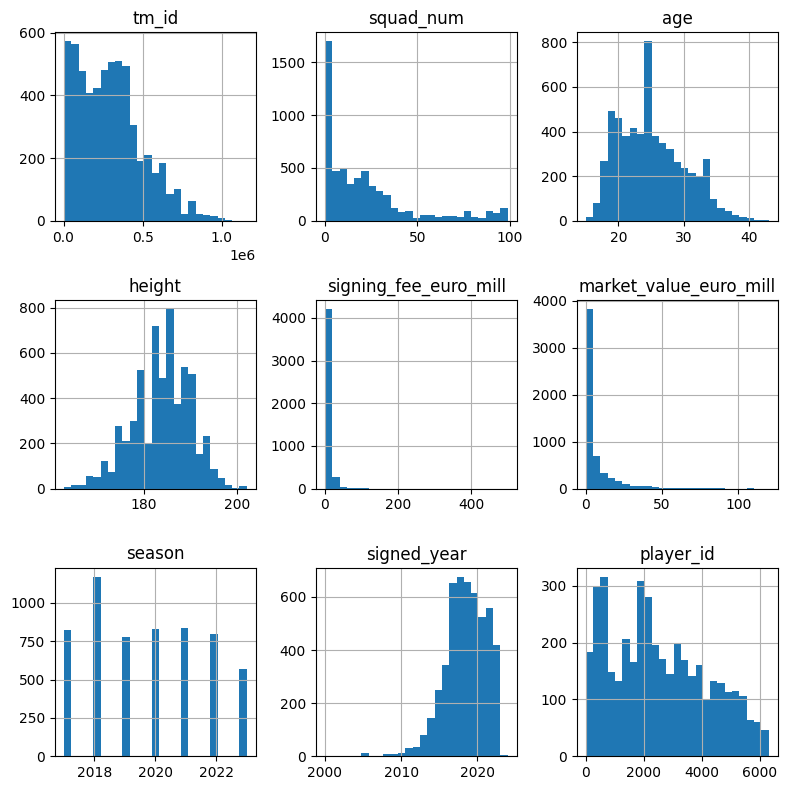

In [5]:
# plot distributions of the data
df.hist(bins=25, figsize=(8,8))
plt.tight_layout()
plt.show()

In [7]:
# initialise plotter
plots = PlayerValsPlots(df)

## Position Analysis

In [8]:
plots.valuation_plot('position')

## Country Analysis

In [9]:
plots.valuation_plot('country')

In [10]:
# plot total players for each season by country - timeseries
plots.var_totals_plot('country')

## Team Analysis

In [11]:
plots.valuation_plot('team')

In [12]:
# for each season, get the average difference between signing fee and market value for the players that were signed by team
dfs = []
for year in df["season"].unique():
    dff = df.loc[(df["season"] == year) & (df["signed_year"] == year)]
    dff.loc[:, "diff_sign_fee_mv"] = (
        dff["market_value_euro_mill"] - dff["signing_fee_euro_mill"]
    )
    dfff = (
        dff.groupby("team")["diff_sign_fee_mv"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()
    )
    dfff.loc[:, "season"] = year
    dfs.append(dfff)

df_diff_sign_fee_mv = pd.concat(dfs)

df_diff_sign_fee_mv.head()

,team,diff_sign_fee_mv,season
0,as-rom,5.985000,2017
1,lazio-rom,2.660000,2017
2,juventus-turin,2.144444,2017
3,sampdoria-genua,1.677778,2017
4,ac-florenz,1.538000,2017


In [13]:
px.line(
    df_diff_sign_fee_mv,
    x="season",
    y="diff_sign_fee_mv",
    color="team",
    title="Average difference between signing fee and end of season market value over time",
)

## Signing Value Analysis

In [14]:
plots.plot_diff_val_paid(column='team')

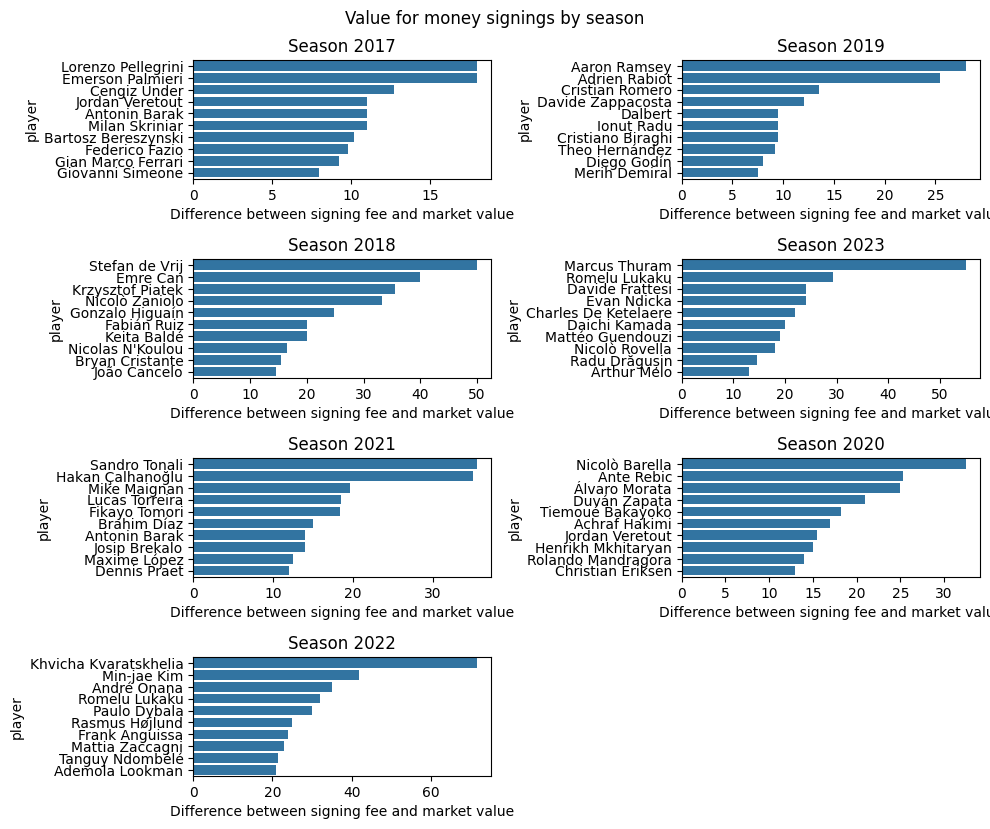

In [15]:
plots.plot_value_signings()

## Height Analysis

In [16]:
plots.valuation_plot('height')

## Foot Analysis

In [17]:
plots.valuation_plot('foot')

## Age Analysis

In [18]:
plots.valuation_plot('age')

In [19]:
plots.plot_diff_val_paid('age')